### Import libraries

In [1]:
# Core Libraries for Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utility Libraries
import warnings

# Exception Handling
from sklearn.exceptions import ConvergenceWarning

# Handling Imbalanced Datasets
from imblearn.over_sampling import SMOTE

# Statistical Functions
from scipy.stats import skew

# Data Preprocessing and Transformation
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler

# Pipeline Construction
from imblearn.pipeline import Pipeline

# Feature Engineering for Heterogeneous Data
from sklearn.compose import ColumnTransformer

# Data Splitting and Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Feature Selection Techniques
from sklearn.feature_selection import SelectKBest, f_classif

# Model Evaluation Metrics
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report, confusion_matrix

### Load Dataset

In [2]:
loan= pd.read_csv(r'../data/loan.csv')    # Load the dataset
loan.head()                               

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
loan.info()        # concise summary information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [4]:
# numerical features 
numerical_col=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# nominal categorical features
categorical_col= ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# ordinal categorical features
ordinal_category= ['Dependents']

### Data analysis
In the data analysis phase, distributions of numerical and categorical features were visualized to understand their characteristics.

In [5]:
loan.describe()        # Descriptive statistics for numerical columns 

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Numeric analysis
- Applicant Income: Most applicants have low to moderate income; a few outliers earn much more.
- Coapplicant Income: Frequently zero, suggesting many single applicants or inactive coapplicants.
- Loan Amount: Most loans are in a moderate range; very large loans are rare.
- Loan Amount Term: Majority of loans have a term of 360 months (30 years).
- Credit History: Most applicants with a positive credit history (value 1) are approved.




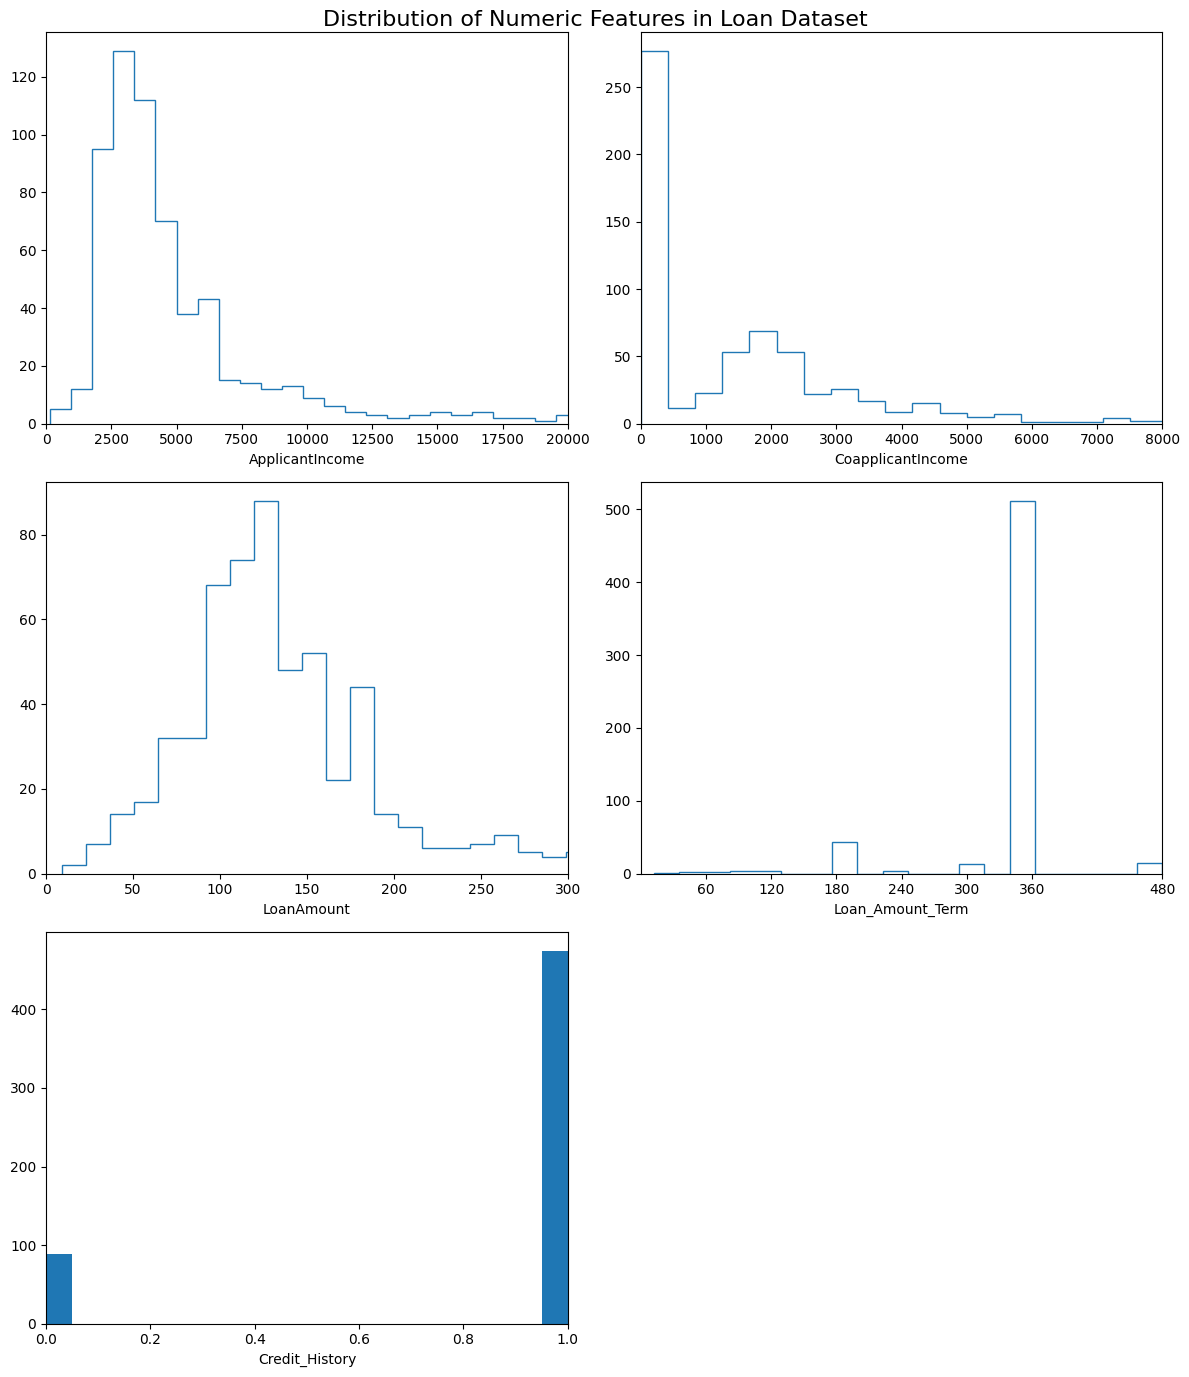

In [6]:
# Visualize the distribution of key numerical features

fig, ax= plt.subplots(3,2, figsize=(12,14))
ax = ax.ravel()

# Plot histogram for 'ApplicantIncome'
ax[0].hist(loan['ApplicantIncome'], bins=100, histtype='step')
ax[0].set_xlim(0, 20000)
ax[0].set_xlabel('ApplicantIncome')

# Plot histogram for 'CoapplicantIncome'
ax[1].hist(loan['CoapplicantIncome'], bins=100, histtype='step')
ax[1].set_xlim(0, 8000)
ax[1].set_xlabel('CoapplicantIncome')

# Plot histogram for 'LoanAmount'
ax[2].hist(loan['LoanAmount'], bins=50, histtype='step')
ax[2].set_xlim(0, 300)
ax[2].set_xlabel('LoanAmount')

# Plot histogram for 'Loan_Amount_Term'
ax[3].hist(loan['Loan_Amount_Term'], bins=20, histtype='step')
ax[3].set_xlim(0, 480)
ax[3].set_xlabel('Loan_Amount_Term')
ax[3].set_xticks([60, 120, 180, 240, 300, 360, 480])

# Plot histogram for 'Credit_History'
ax[4].hist(loan['Credit_History'], bins=20)
ax[4].set_xlim(0, 1)
ax[4].set_xlabel('Credit_History')

# Remove the last empty subplot
fig.delaxes(ax[5])

fig.suptitle('Distribution of Numeric Features in Loan Dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# Function to visualize the distribution of categorical features 

def loan_category(col_name, axix_number):
    # Group the dataset by 'Loan_Status' and the specified categorical feature
    loan_category= (
    loan.groupby(['Loan_Status', col_name], as_index=False)
    .agg(total=('Loan_Status', 'count'))                                               
    .pivot(index='Loan_Status', columns=col_name, values='total')                   
    )

    # unique category values
    unique_cols = loan_category.columns.tolist()

    # color
    color_palette = ['#FF9999', '#99CCFF', "#097AAF", '#FFCC99', '#CCCCCC']  
    colors = {k: v for k, v in zip(unique_cols, color_palette)}
    color_list = [colors[col] for col in loan_category.columns] 

    # Plot
    ax[axix_number]= loan_category.plot(kind='bar', color=color_list, ax=ax[axix_number])

    ax[axix_number].spines[['top', 'right']].set_visible(False)

    # value labels
    for container in ax[axix_number].containers:
         ax[axix_number].bar_label(container, label_type='center', alpha=0.7)

    # X-axis ticks and labels ('No', 'Yes') representing Loan_Status
    ax[axix_number].set_xticks(ticks=[0,1], labels=['No', 'Yes'] , rotation=0)
    ax[axix_number].set_xlabel(f"Loan Status")
    ax[axix_number].set_ylabel('count')

### Analatical analysis
- Gender: Males have a much higher loan approval rate than females.
- Married: Married applicants are approved more often than unmarried ones.
- Education: Graduates are more likely to get approved than non-graduates.
- Self_Employed: Non-self-employed applicants dominate approved loans.
- Property Area: Most approvals are from semiurban and urban areas.
- Dependents: Applicants with fewer dependents (especially zero) have higher approval rates.


### Conclusion:
Loan approvals strongly favor applicants with higher stability (male, married, graduate, non-self-employed, fewer dependents, good credit). Most loans are for standard amounts and terms.

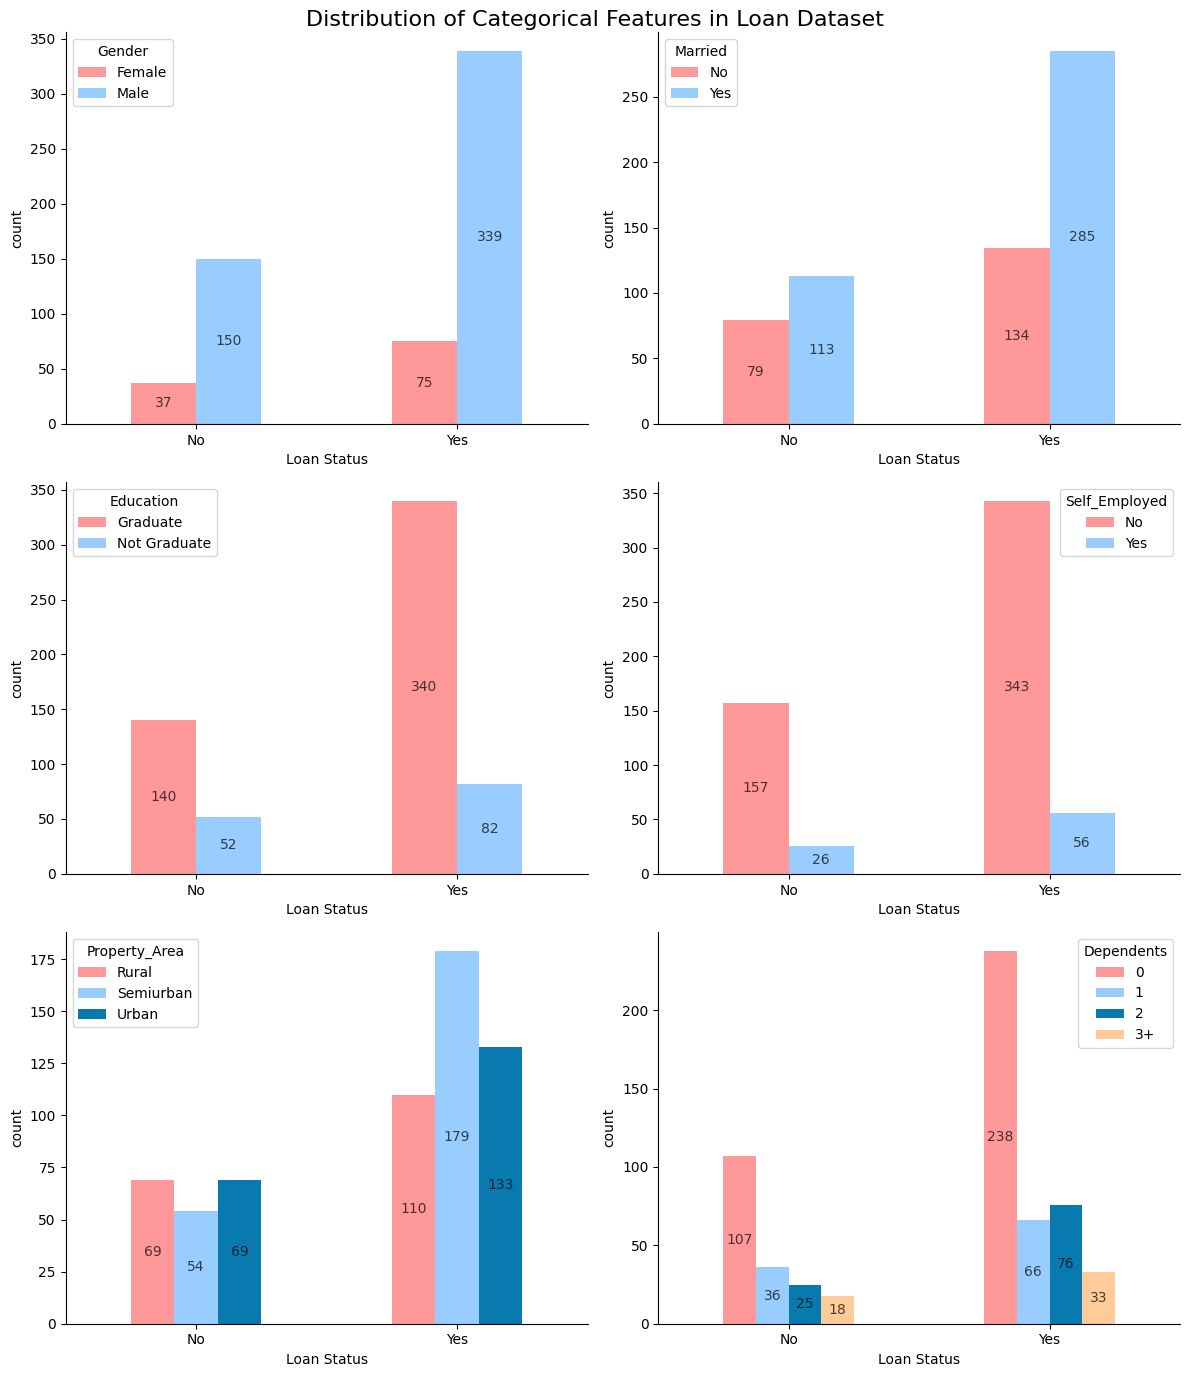

In [8]:
# bar plot for each selected categorical feature

fig, ax= plt.subplots(3,2, figsize=(12,14))
ax = ax.ravel()
loan_category('Gender', 0)
loan_category('Married', 1)
loan_category('Education', 2)
loan_category('Self_Employed', 3)
loan_category('Property_Area', 4)
loan_category('Dependents', 5)

plt.suptitle('Distribution of Categorical Features in Loan Dataset', fontsize=16)
plt.tight_layout() 
plt.show()

### Missing values
Missing values were imputed based on feature characteristics, using either the mean or the most frequent value, depending on the distribution and nature of each numerical or categorical variable

In [9]:
# numerical features
loan['LoanAmount']= loan['LoanAmount'].fillna(loan['LoanAmount'].mean())
loan['Loan_Amount_Term']= loan['Loan_Amount_Term'].fillna(loan['Loan_Amount_Term'].mode()[0])
loan['Credit_History']= loan['Credit_History'].fillna(loan['Credit_History'].mode()[0])

# categorical features
loan['Gender']= loan['Gender'].fillna(loan['Gender'].mode()[0])
loan['Married']= loan['Married'].fillna(loan['Married'].mode()[0])
loan['Self_Employed']= loan['Self_Employed'].fillna(loan['Self_Employed'].mode()[0])

# ordinal categorical features
loan['Dependents']= loan['Dependents'].fillna(loan['Dependents'].mode()[0])

In [10]:
# Check for any remaining missing values 
loan.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Feature Engineering
Several new features were engineered to enhance the predictive power of the dataset:

- Total_Income:
Represents the combined income of the applicant and coapplicant, providing a more comprehensive view of an applicant’s repayment capacity.

- Loan_Income_Ratio:
Captures the proportion of the requested loan amount relative to total income, serving as an indicator of borrower affordability and financial risk.

- Income_per_Person:
Measures income allocation per household member, calculated as total income divided by (number of dependents + 1), which accounts for the applicant.

- Income_Category:
Categorizes applicants into income quartiles (‘Low’, ‘Lower-Middle’, ‘Upper-Middle’, ‘High’) using quantile-based discretization, enabling the model to leverage income segments as a categorical feature.

- Educated_Self_Employed:
A binary indicator identifying applicants who are both graduates and self-employed, potentially capturing distinct borrower profiles with unique risk patterns.


These engineered features were designed to provide deeper insights into applicants’ economic situations and may help improve the model’s ability to distinguish between loan approvals and rejections.

In [11]:
# capturing the complete household earning power, which is often a stronger predictor for loan approval.
loan['Total_Income']= loan['ApplicantIncome']+ loan['CoapplicantIncome']


# it reflects the applicant's debt-to-income burden.
loan['Loan_Income_Ratio']= loan['LoanAmount']/ (loan['Total_Income']) 


# providing a measure of income available to each household member.
loan['Dependents']= loan['Dependents'].replace('3+', 3)
loan['Dependents']= loan['Dependents'].astype(int)
loan['Income_per_Person']= loan['Total_Income'] / (loan['Dependents'] + 1) 


# Categorize 'Total_Income' into four quantile-based bins.
loan['Income_Category']= pd.qcut(loan['Total_Income'], q=4, labels=['Low', 'Lower-Middle', 'Upper-Middle', 'High'])


# This composite feature captures the combined effect of education and self-employment.
loan['Educated_Self_Employed']= ((loan['Education'] == 'Graduate') & (loan['Self_Employed'] == 'Yes')).astype(int)

loan.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Loan_Income_Ratio,Income_per_Person,Income_Category,Educated_Self_Employed
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,5849.0,0.025032,5849.0,Upper-Middle,0
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0,0.021015,3045.5,Upper-Middle,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0,0.022000,3000.0,Low,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0,0.024287,4941.0,Lower-Middle,0
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0,0.023500,6000.0,Upper-Middle,0


In [12]:
# Update feature groupings after engineering new variables

numerical_col=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                'Credit_History', 'Total_Income', 'Loan_Income_Ratio', 'Income_per_Person', 'Educated_Self_Employed', ]

categorical_col= ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

ordinal_category= ['Dependents', 'Income_Category']

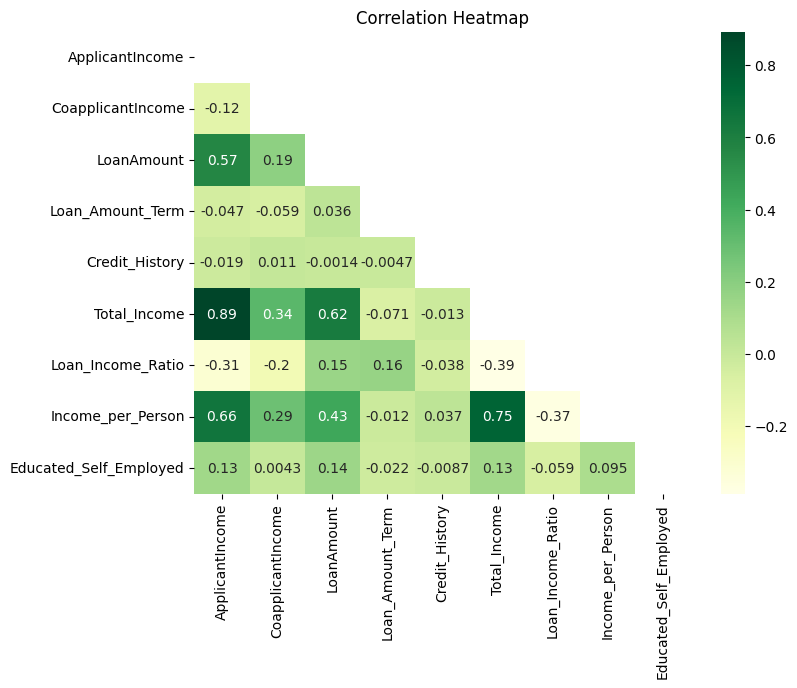

In [13]:
# Plot upper triangle correlation heatmap of numerical features

mask= np.triu(np.ones_like(loan[numerical_col].corr(), dtype=bool))

plt.figure(figsize=(8,6))
sns.heatmap(loan[numerical_col].corr(), mask=mask, cmap="YlGn", annot=True)
plt.title("Correlation Heatmap")
plt.show()

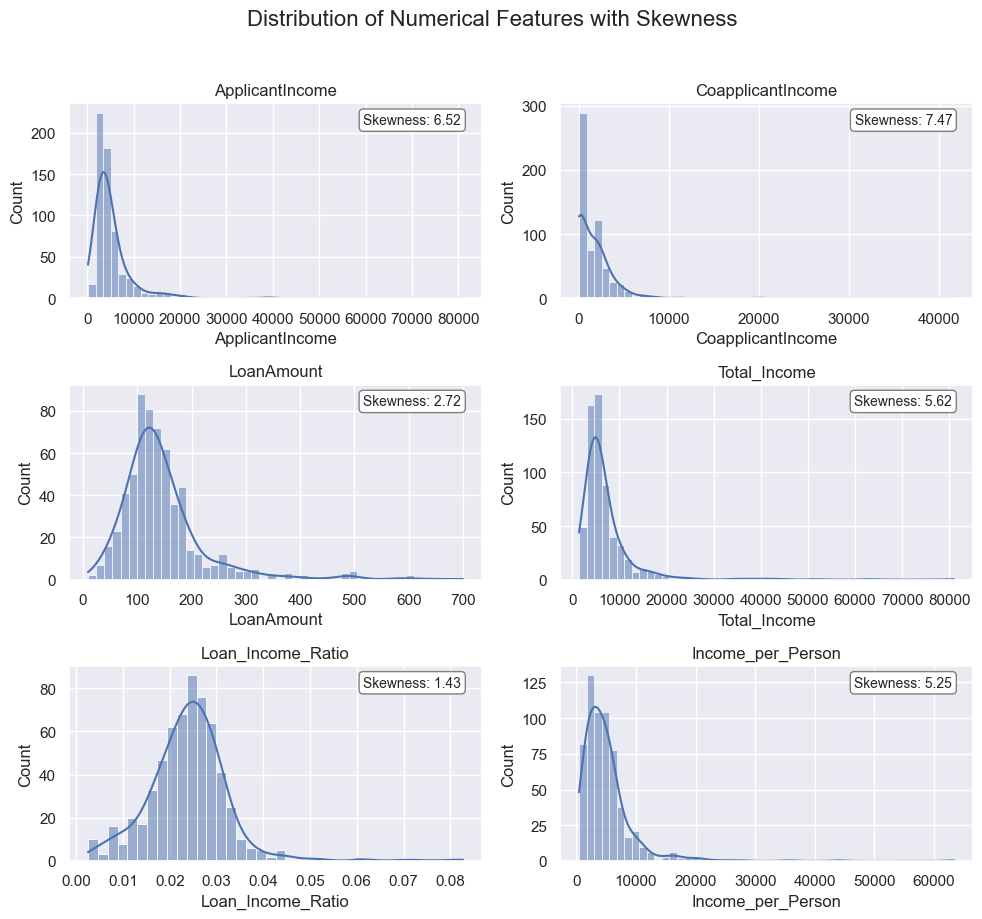

In [14]:
# Visualize distribution and skewness of numerical features

sns.set(style="darkgrid")
fig, axs= plt.subplots(3, 2, figsize=(10, 9))
fig.suptitle("Distribution of Numerical Features with Skewness", fontsize=16, y=1.02)
axs= axs.ravel()


# List of selected numerical features to visualize
columns= ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Total_Income', 'Loan_Income_Ratio', 'Income_per_Person']


for i, col in enumerate(columns):
    sns.histplot(data=loan, x=col, kde=True, ax=axs[i])
    
    skewness= skew(loan[col])
    
    axs[i].text(
        0.95, 0.95,
        f"Skewness: {skewness:.2f}",
        horizontalalignment='right',
        verticalalignment='top',
        transform=axs[i].transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray')
    )

    axs[i].set_title(col)

plt.tight_layout()
plt.show()


### Remove outliers from numerical features 
Outliers in numerical distributions were detected and removed using the IQR method, considering the 15th and 85th percentiles due to the heavy-tailed nature of the data

In [15]:
before_rows= loan.shape[0]

# Compute the 15th (Q1) and 85th (Q3) percentiles
Q1= loan[columns].quantile(0.15)
Q3= loan[columns].quantile(0.85)

# Calculate the interquartile range (IQR) between the 15th and 85th percentiles
IQR= Q3 - Q1

# Remove rows where any selected feature is an outlier 
loan= loan[~((loan[columns] < (Q1 - 1.5 * IQR)) |(loan[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

after_rows= loan.shape[0]
print(f"Rows before removing outliers: {before_rows}")
print(f"Rows after removing outliers: {after_rows}")
print(f"Rows removed: {before_rows - after_rows}")

Rows before removing outliers: 614
Rows after removing outliers: 566
Rows removed: 48


### Define preprocessing pipelines
- Numerical Features:
Since the numerical features are not normally distributed and exhibit noticeable skewness (as shown in the earlier histograms), square root transformation is applied to reduce skewness, followed by standard scaling to ensure features have zero mean and unit variance.

- Categorical Features:
Categorical variables are processed using one-hot encoding to convert them into binary indicator variables suitable for modeling.

- Ordinal Features:
Ordinal variables are encoded using ordinal encoding, preserving the natural order inherent in these categories.


In [16]:
sqrt_transformer= FunctionTransformer(np.sqrt, validate=True)

# Apply square root to reduce numerical skew, then standardize
numerical_pipeline= Pipeline([
    ('sqrt_tr', sqrt_transformer),
    ('scale', StandardScaler())
])

# One-hot encode nominal categories, ignore unknowns.
categorical_pipeline= Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Encode ordinal features
ordinal_pipeline= Pipeline([
    ('ordinal', OrdinalEncoder(categories=[['0', '1', '2', '3'], ['Low', 'Lower-Middle', 'Upper-Middle', 'High']]))
])

In [17]:
# Combine all preprocessing pipelines by feature type.

preprocessor= ColumnTransformer([
    ('numerical', numerical_pipeline, columns),                # Numerical features: sq. root + scaling
    ('categorical', categorical_pipeline, categorical_col),    # Categorical features: one-hot encoding
    ('ordinal', ordinal_pipeline, ordinal_category)            # Ordinal features: order-based encoding
])

processed_array= preprocessor.fit_transform(loan)              # Apply all preprocessing steps to the dataset

In [18]:
# Get feature names for one-hot encoded categorical columns
OHE_feature_names= preprocessor.named_transformers_['categorical']['one_hot'].get_feature_names_out(categorical_col)

# Concatenate all feature names
all_feature_names= list(columns) + list(OHE_feature_names) + list(ordinal_category)

# Rebuild DataFrame from processed array
new_loan= pd.DataFrame(processed_array, columns=all_feature_names)

# Re-attach target label and essential columns
new_loan['Loan_Status']= loan['Loan_Status'].values
new_loan['Loan_Amount_Term']= loan['Loan_Amount_Term'].values
new_loan['Credit_History']= loan['Credit_History'].values

loan= new_loan
loan.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Total_Income,Loan_Income_Ratio,Income_per_Person,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Dependents,Income_Category,Loan_Status,Loan_Amount_Term,Credit_History
0,0.727876,-1.063758,0.348399,0.120024,0.202194,0.725483,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,2.0,Y,360.0,1.0
1,0.195560,0.462879,0.006860,0.221162,-0.346263,-0.402617,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,2.0,N,360.0,1.0
2,-0.588018,-1.063758,-1.378469,-1.281764,-0.207200,-0.424540,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Y,360.0,1.0
3,-0.827417,0.845247,-0.149172,-0.279496,0.103954,0.397718,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,Y,360.0,1.0
4,0.787341,-1.063758,0.250353,0.183370,-0.001361,0.777453,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,2.0,Y,360.0,1.0


### Improved Distribution After Transformation

After applying the square root transformation and scaling, the numerical features exhibit distributions that are much closer to normal, with substantially reduced skewness values (e.g., ApplicantIncome skewness: 0.93, CoapplicantIncome: 0.14).

This significant reduction in skewness compared to the original data (where skewness values were above 5) demonstrates the effectiveness of the preprocessing pipeline in normalizing feature distributions and improving data suitability for subsequent modeling.


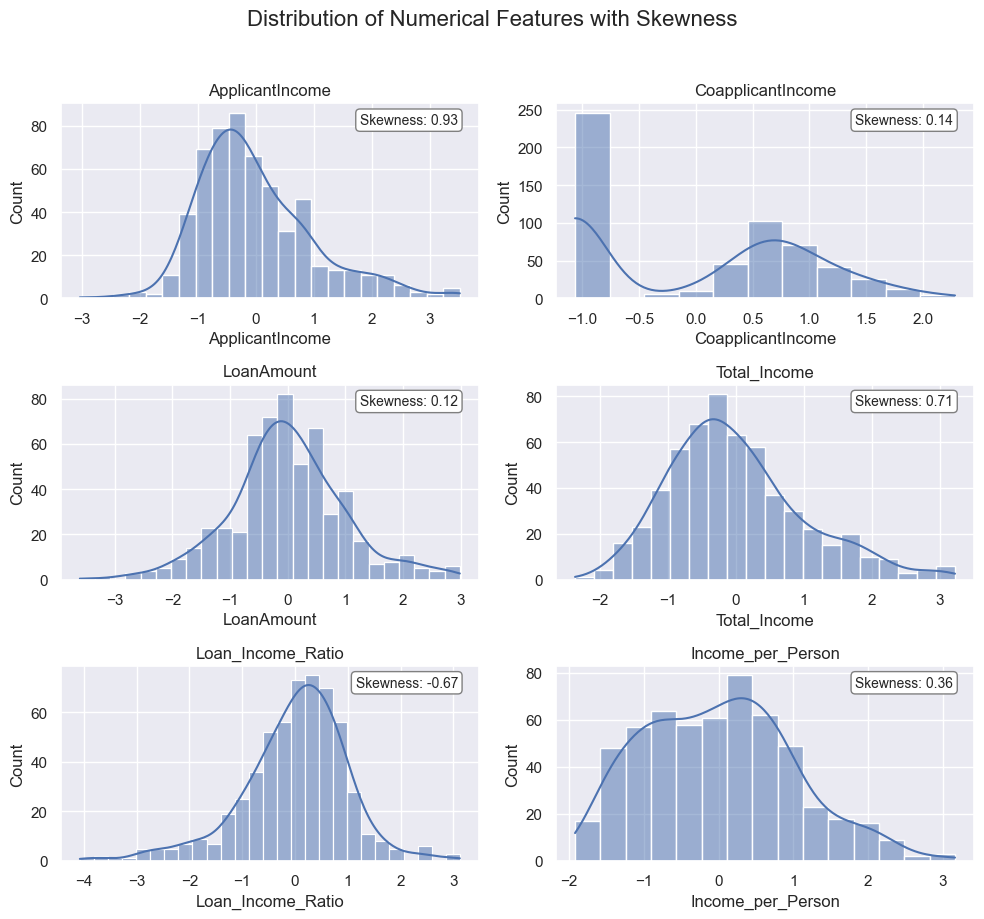

In [19]:
# Visualize distribution and skewness of numerical features after normalization

sns.set(style="darkgrid")
fig, axs= plt.subplots(3, 2, figsize=(10, 9))
fig.suptitle("Distribution of Numerical Features with Skewness", fontsize=16, y=1.02)
axs= axs.ravel()

columns= ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Total_Income', 'Loan_Income_Ratio', 'Income_per_Person']


for i, col in enumerate(columns):
    sns.histplot(data=loan, x=col, kde=True, ax=axs[i])
    
    skewness= skew(loan[col])
    
    axs[i].text(
        0.95, 0.95,
        f"Skewness: {skewness:.2f}",
        horizontalalignment='right',
        verticalalignment='top',
        transform=axs[i].transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray')
    )

    axs[i].set_title(col)

plt.tight_layout()
plt.show()


### Data Preparation and Splitting

To prepare the data for modeling, the target variable Loan_Status was separated from the feature set and encoded to binary format (0 for rejection and 1 for approval). The dataset was then randomly stratified and split into training and test sets, with 15% of the data reserved for evaluating model performance. Stratification was applied to ensure that the distribution of the target classes remains consistent across both splits.

The data split ensures unbiased model evaluation and maintains class proportions, which is especially important in the presence of imbalanced target classes.

In [20]:
X= loan.drop(['Loan_Status'], axis=1)
y= loan['Loan_Status'].map({'N':0, 'Y':1})

# Split data into train and test sets (15% test), preserving class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [21]:
# Compare model performance (accuracy, F1, recall) across baseline, GridSearch, and threshold-adjusted versions.

def scores(y_test, model, grid, y_test_pred):
    scores= pd.DataFrame({
    'Model': ['Initial', 'GridSearch', 'Threshold-based'],
    
    'Accuracy': [
        round(accuracy_score(y_test, model.predict(X_test)), 2),
        round(accuracy_score(y_test, grid.predict(X_test)), 2),
        round(accuracy_score(y_test, y_test_pred), 2)
    ],
    
    'F1-score': [
        round(f1_score(y_test, model.predict(X_test), average='weighted'), 2),
        round(f1_score(y_test, grid.predict(X_test), average='weighted'), 2),
        round(f1_score(y_test, y_test_pred, average='weighted'), 2)
    ],
    
    'Recall_0': [
        round(recall_score(y_test, model.predict(X_test), pos_label=0), 2),
        round(recall_score(y_test, grid.predict(X_test), pos_label=0), 2),
        round(recall_score(y_test, y_test_pred, pos_label=0), 2)
    ]
    })

    return scores

### Model Training and Hyperparameter Tuning

To address class imbalance in the target variable, all model training pipelines incorporated SMOTE oversampling as the first step. Each pipeline included feature selection via SelectKBest (using the ANOVA F-score) followed by a classification algorithm.

Logistic regression with class weighting was first implemented, and subsequently, this approach was systematically applied to seven different classification models. For each model, hyperparameters were tuned using GridSearchCV with 5-fold cross-validation, optimizing for the macro-averaged F1 score. The optimal configuration identified by the grid search was then used to refit the pipeline on the training data, and test set predictions were made based on the best estimator.

To further account for the imbalanced dataset, a custom probability threshold was applied for classification, and model performance was evaluated using the confusion matrix, accuracy, F1-score, and recall.

LogisticRegression

In [22]:
# Suppress convergence warnings to keep output clean.
warnings.filterwarnings('ignore', category=ConvergenceWarning)

model= LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Build a pipeline: SMOTE for oversampling, SelectKBest for feature selection, then logistic regression.
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('model', model)
])

param_grid = {
    'select_k_best__k': [10, 'all'],
    'model__C': [0.01, 0.1],
    'model__penalty': ['l1'],
    'model__solver': ['liblinear'],
    'model__max_iter': [300, 500]
}

# Grid search with 5-fold CV, optimizing for macro-averaged F1 score.
grid= GridSearchCV(pipeline, param_grid, cv=5, scoring= 'f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)


print(grid.best_params_)

{'model__C': 0.1, 'model__max_iter': 300, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'select_k_best__k': 'all'}


In [23]:
best_model= grid.best_estimator_                    # Best model found by GridSearchCV 
best_model.fit(X_train, y_train)

y_proba= best_model.predict_proba(X_test)[:, 1]     # Predict class probabilities for the test set

y_test_pred= (y_proba >= 0.24).astype(int)          # Classify test samples using a custom probability threshold (0.24)

scores(y_test, model, grid, y_test_pred)            # Evaluate and compare model performances 

,Model,Accuracy,F1-score,Recall_0
0,Initial,0.82,0.82,0.73
1,GridSearch,0.85,0.84,0.62
2,Threshold-based,0.87,0.86,0.62


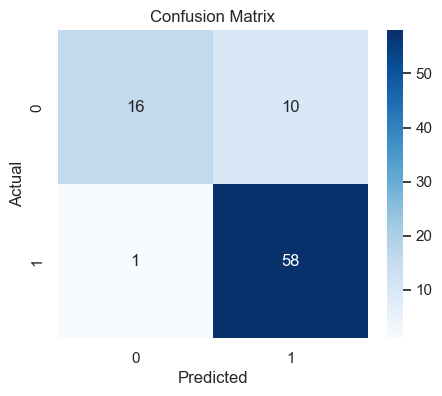

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.62      0.74        26
           1       0.85      0.98      0.91        59

    accuracy                           0.87        85
   macro avg       0.90      0.80      0.83        85
weighted avg       0.88      0.87      0.86        85

Accuracy: 0.87


In [24]:
# Compute the confusion matrix
cm= confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

# Overall accuracy
acc_log= accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {acc_log:.2f}")

# Extract the weighted average F1-score and recall for the negative class ('0')
report= classification_report(y_test, y_test_pred, output_dict=True)
f1_log= report['weighted avg']['f1-score']
recall_log= report['0']['recall']

KNeighborsClassifier

In [25]:
model= KNeighborsClassifier()
model.fit(X_train, y_train)

# Build a pipeline: SMOTE for oversampling, SelectKBest for feature selection, then KNeighbors Classifier.
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('model', model)
])

param_grid= {
    'select_k_best__k': [5, 10, 'all'],
    'model__n_neighbors': range(1, 21),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}
# Grid search with 5-fold CV, optimizing for macro-averaged F1 score.
grid= GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)


print(grid.best_params_)

{'model__metric': 'euclidean', 'model__n_neighbors': 19, 'model__weights': 'uniform', 'select_k_best__k': 5}


In [26]:
best_model= grid.best_estimator_                   # Best model found by GridSearchCV 
best_model.fit(X_train, y_train)

y_proba= best_model.predict_proba(X_test)[:, 1]    # Predict class probabilities for the test set

y_test_pred = (y_proba >= 0.16).astype(int)        # Classify test samples using a custom probability threshold (0.16)

scores(y_test, model, grid, y_test_pred)           # Evaluate and compare model performances 

,Model,Accuracy,F1-score,Recall_0
0,Initial,0.73,0.70,0.31
1,GridSearch,0.86,0.85,0.62
2,Threshold-based,0.86,0.85,0.62


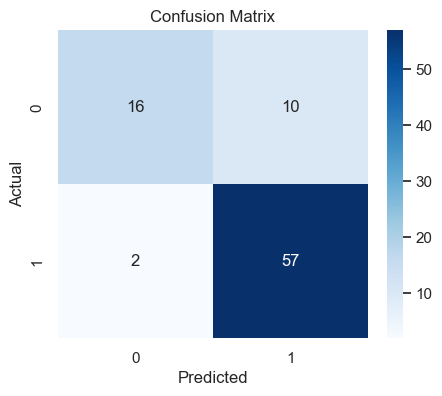

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.62      0.73        26
           1       0.85      0.97      0.90        59

    accuracy                           0.86        85
   macro avg       0.87      0.79      0.82        85
weighted avg       0.86      0.86      0.85        85

Accuracy: 0.86


In [27]:
# Compute the confusion matrix
cm= confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

# Overall accuracy
acc_knn= accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {acc_knn:.2f}")

# Extract the weighted average F1-score and recall for the negative class ('0')
report= classification_report(y_test, y_test_pred, output_dict=True)
f1_knn= report['weighted avg']['f1-score']
recall_knn= report['0']['recall']

MLP

In [28]:
model= MLPClassifier(random_state=42)
model.fit(X_train, y_train)

# Build a pipeline: SMOTE for oversampling, SelectKBest for feature selection, then MLP Classifier.
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('model', model)
])

param_grid = {
    'select_k_best__k': [5, 'all'],
    'model__hidden_layer_sizes': [(50,), (100,)],
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['adam'],
    'model__alpha': [0.0001, 0.001],
    'model__learning_rate_init': [0.001, 0.01],
    'model__max_iter': [300]
}

# Grid search with 5-fold CV, optimizing for macro-averaged F1 score.
grid= GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (50,), 'model__learning_rate_init': 0.01, 'model__max_iter': 300, 'model__solver': 'adam', 'select_k_best__k': 5}


In [29]:
best_model= grid.best_estimator_                   # Best model found by GridSearchCV 
best_model.fit(X_train, y_train)

y_proba= best_model.predict_proba(X_test)[:, 1]    # Predict class probabilities for the test set

y_test_pred= (y_proba >= 0.07).astype(int)         # Classify test samples using a custom probability threshold (0.07)

scores(y_test, model, grid, y_test_pred)           # Evaluate and compare model performances 

,Model,Accuracy,F1-score,Recall_0
0,Initial,0.84,0.82,0.54
1,GridSearch,0.86,0.85,0.62
2,Threshold-based,0.86,0.85,0.62


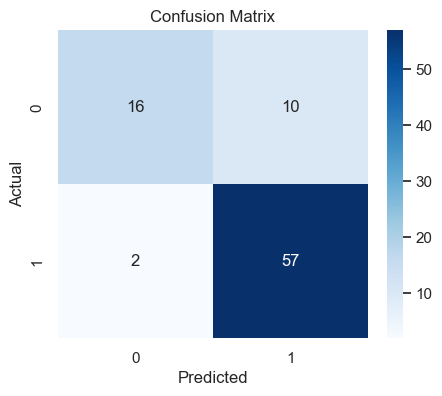

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.62      0.73        26
           1       0.85      0.97      0.90        59

    accuracy                           0.86        85
   macro avg       0.87      0.79      0.82        85
weighted avg       0.86      0.86      0.85        85

Accuracy: 0.86


In [30]:
# Compute the confusion matrix
cm= confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

# Overall accuracy
acc_mlp= accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {acc_mlp:.2f}")

# Extract the weighted average F1-score and recall for the negative class ('0')
report= classification_report(y_test, y_test_pred, output_dict=True)
f1_mlp= report['weighted avg']['f1-score']
recall_mlp= report['0']['recall']

RandomForestClassifier

In [31]:
model= RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Build a pipeline: SMOTE for oversampling, SelectKBest for feature selection, then RandomForest Classifier.
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('model', model)
])

param_grid = {
    'select_k_best__k': [10, 'all'],
    'model__n_estimators': [200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt'],
    'model__bootstrap': [True],
}

# Grid search with 5-fold CV, optimizing for macro-averaged F1 score.
grid= GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200, 'select_k_best__k': 'all'}


In [32]:
best_model= grid.best_estimator_                   # Best model found by GridSearchCV 
best_model.fit(X_train, y_train)

y_proba= best_model.predict_proba(X_test)[:, 1]    # Predict class probabilities for the test set

y_test_pred= (y_proba >= 0.27).astype(int)         # Classify test samples using a custom probability threshold (0.27)

scores(y_test, model, grid, y_test_pred)           # Evaluate and compare model performances 

,Model,Accuracy,F1-score,Recall_0
0,Initial,0.86,0.85,0.65
1,GridSearch,0.85,0.84,0.65
2,Threshold-based,0.86,0.85,0.62


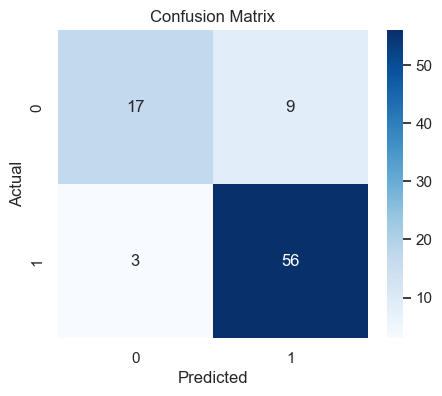

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.65      0.74        26
           1       0.86      0.95      0.90        59

    accuracy                           0.86        85
   macro avg       0.86      0.80      0.82        85
weighted avg       0.86      0.86      0.85        85

Accuracy: 0.86


In [33]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, model.predict(X_test)))

# Overall accuracy
acc_rf= accuracy_score(y_test, model.predict(X_test))
print(f"Accuracy: {acc_rf:.2f}")

# Extract the weighted average F1-score and recall for the negative class ('0')
report= classification_report(y_test, model.predict(X_test), output_dict=True)
f1_rf= report['weighted avg']['f1-score']
recall_rf= report['0']['recall']

DecisionTreeClassifier

In [34]:
model= DecisionTreeClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Build a pipeline: SMOTE for oversampling, SelectKBest for feature selection, then DecisionTree Classifier.
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('model', model)
])

param_grid = {
    'select_k_best__k': [5, 10, 'all'],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': [None, 'sqrt'],
    'model__criterion': ['gini']
}

# Grid search with 5-fold CV, optimizing for macro-averaged F1 score.
grid= GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'select_k_best__k': 5}


In [35]:
best_model= grid.best_estimator_                   # Best model found by GridSearchCV 
best_model.fit(X_train, y_train)

y_proba= best_model.predict_proba(X_test)[:, 1]    # Predict class probabilities for the test set

y_test_pred= (y_proba >= 0.33).astype(int)         # Classify test samples using a custom probability threshold (0.33)

scores(y_test, model, grid, y_test_pred)           # Evaluate and compare model performances 

,Model,Accuracy,F1-score,Recall_0
0,Initial,0.82,0.83,0.77
1,GridSearch,0.86,0.85,0.62
2,Threshold-based,0.86,0.85,0.62


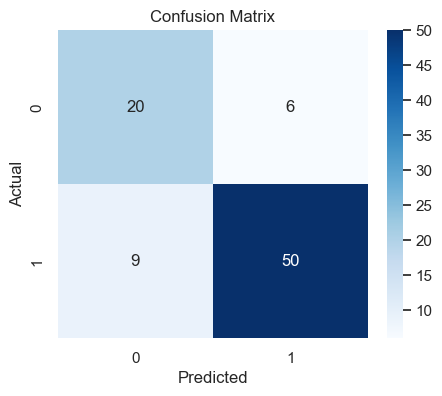

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.77      0.73        26
           1       0.89      0.85      0.87        59

    accuracy                           0.82        85
   macro avg       0.79      0.81      0.80        85
weighted avg       0.83      0.82      0.83        85

Accuracy: 0.82


In [36]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, model.predict(X_test)))

# Overall accuracy
acc_dt= accuracy_score(y_test, model.predict(X_test))
print(f"Accuracy: {acc_dt:.2f}")

# Extract the weighted average F1-score and recall for the negative class ('0')
report= classification_report(y_test, model.predict(X_test), output_dict=True)
f1_dt= report['weighted avg']['f1-score']
recall_dt= report['0']['recall']

GaussianNB

In [37]:
model= GaussianNB()
model.fit(X_train, y_train)

# Build a pipeline: SMOTE for oversampling, SelectKBest for feature selection, then GaussianNB.
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('model', model)
])

param_grid = {
    'select_k_best__k': [5, 7, 10, 'all'],
    'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Grid search with 5-fold CV, optimizing for macro-averaged F1 score.
grid= GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'model__var_smoothing': 1e-09, 'select_k_best__k': 5}


In [38]:
best_model= grid.best_estimator_                   # Best model found by GridSearchCV 
best_model.fit(X_train, y_train)

y_proba= best_model.predict_proba(X_test)[:, 1]    # Predict class probabilities for the test set

y_test_pred= (y_proba >= 0.68).astype(int)         # Classify test samples using a custom probability threshold (0.68)

scores(y_test, model, grid, y_test_pred)           # Evaluate and compare model performances 

,Model,Accuracy,F1-score,Recall_0
0,Initial,0.86,0.85,0.62
1,GridSearch,0.86,0.85,0.62
2,Threshold-based,0.82,0.82,0.65


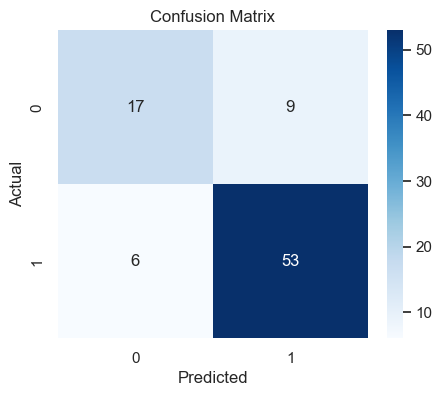

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.65      0.69        26
           1       0.85      0.90      0.88        59

    accuracy                           0.82        85
   macro avg       0.80      0.78      0.78        85
weighted avg       0.82      0.82      0.82        85

Accuracy: 0.82


In [39]:
# Compute the confusion matrix
cm= confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

# Overall accuracy
acc_g= accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {acc_g:.2f}")

# Extract the weighted average F1-score and recall for the negative class ('0')
report= classification_report(y_test, y_test_pred, output_dict=True)
f1_g= report['weighted avg']['f1-score']
recall_g= report['0']['recall']

GradientBoostingClassifier

In [40]:
model= GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Build a pipeline: SMOTE for oversampling, SelectKBest for feature selection, then GradientBoosting Classifier.
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('model', model)
])

param_grid = {
    'select_k_best__k': [10, 'all'],
    'model__n_estimators': [50],
    'model__learning_rate': [0.1],
    'model__max_depth': [3, 5],
    'model__subsample': [0.8, 1.0]
}

# Grid search with 5-fold CV, optimizing for macro-averaged F1 score.
grid= GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 1.0, 'select_k_best__k': 10}


In [41]:
best_model= grid.best_estimator_                     # Best model found by GridSearchCV 
best_model.fit(X_train, y_train)

y_proba= best_model.predict_proba(X_test)[:, 1]      # Predict class probabilities for the test set

y_test_pred= (y_proba >= 0.33).astype(int)           # Classify test samples using a custom probability threshold (0.33)

scores(y_test, model, grid, y_test_pred)             # Evaluate and compare model performances 

,Model,Accuracy,F1-score,Recall_0
0,Initial,0.87,0.87,0.73
1,GridSearch,0.86,0.86,0.69
2,Threshold-based,0.86,0.85,0.65


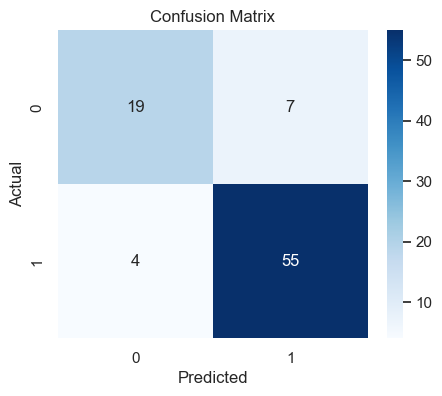

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.73      0.78        26
           1       0.89      0.93      0.91        59

    accuracy                           0.87        85
   macro avg       0.86      0.83      0.84        85
weighted avg       0.87      0.87      0.87        85

Accuracy: 0.87


In [42]:
# Compute the confusion matrix
cm= confusion_matrix(y_test, model.predict(X_test))

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, model.predict(X_test)))

# Overall accuracy
acc_gerad= accuracy_score(y_test, model.predict(X_test))
print(f"Accuracy: {acc_gerad:.2f}")

# Extract the weighted average F1-score and recall for the negative class ('0')
report= classification_report(y_test, model.predict(X_test), output_dict=True)
f1_gerad= report['weighted avg']['f1-score']
recall_gerad= report['0']['recall']

### Model Comparison

To identify the most effective classification algorithm, all seven models were evaluated and compared based on their accuracy, F1-score, and recall for class 0. The results were compiled into a summary table and sorted by accuracy and F1-score. This enables a clear and objective comparison of model performance and facilitates the selection of the optimal model for deployment.

Given the significant risk associated with erroneously approving ineligible applicants, my primary evaluation metric is recall for Class 0 (non-eligible applicants). By maximizing this metric, I aim to minimize the chance of granting loans to individuals who do not meet the eligibility criteria, which could lead to financial losses for the institution.

While missing an eligible applicant (false negative) may result in a lost opportunity, this can often be remedied by resubmission or further review. However, approving an ineligible applicant (false positive) poses a much greater operational risk. Therefore, the model selection prioritizes high recall for non-eligible applicants, ensuring prudent risk management aligned with business objectives.

In [43]:
# Compare and sort models by accuracy and F1-score

compare= pd.DataFrame({'Model': ['LogisticRegression', 'KNeighbors', 
                                  'MLP', 'RandomForest', 
                                  'DecisionTree', 'GaussianNB', 
                                   'GradientBoosting'], 

                        'Accuracy': [acc_log*100, acc_knn*100, acc_mlp*100, 
                                     acc_rf*100, acc_dt*100, acc_g*100, acc_gerad*100],

                        'f1-score': [f1_log*100, f1_knn*100, f1_mlp*100, 
                                     f1_rf*100, f1_dt*100, f1_g*100, f1_gerad*100],

                        'recall_0':   [recall_log*100, recall_knn*100, recall_mlp*100, 
                                     recall_rf*100, recall_dt*100, recall_g*100, recall_gerad*100]})
compare.sort_values(by=['Accuracy', 'f1-score'], ascending=False)

,Model,Accuracy,f1-score,recall_0
6,GradientBoosting,87.058824,86.823093,73.076923
0,LogisticRegression,87.058824,86.163060,61.538462
3,RandomForest,85.882353,85.303193,65.384615
1,KNeighbors,85.882353,85.047110,61.538462
2,MLP,85.882353,85.047110,61.538462
4,DecisionTree,82.352941,82.604046,76.923077
5,GaussianNB,82.352941,82.031490,65.384615


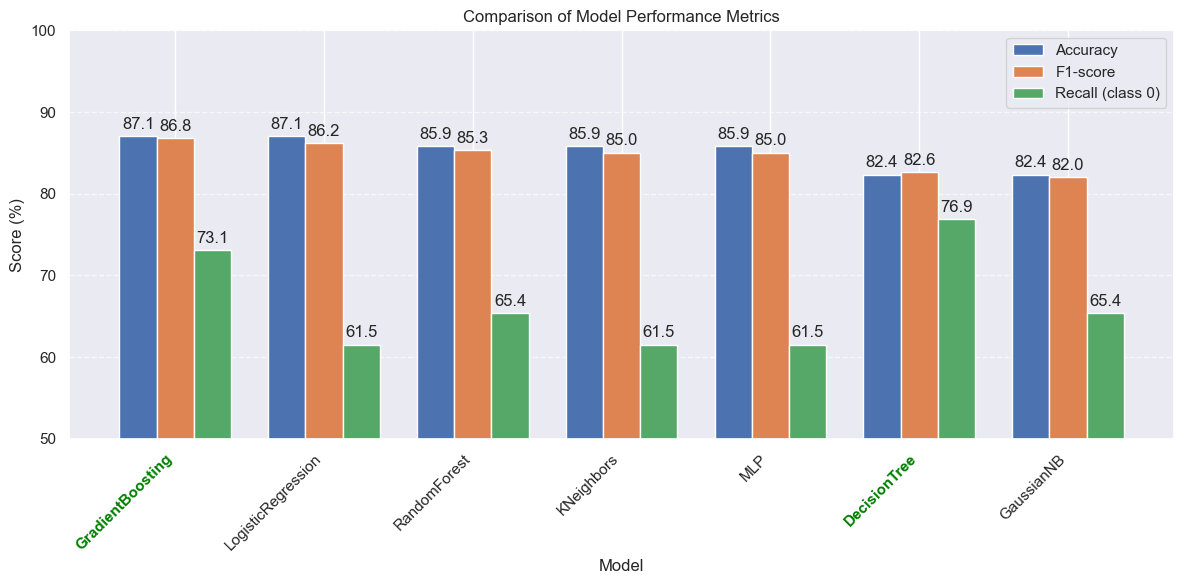

In [44]:
# Visualize model performance comparison with grouped bar chart

compare= compare.sort_values(by=['Accuracy', 'f1-score', 'recall_0'], ascending=False)
compare[['Accuracy', 'f1-score', 'recall_0']] = compare[['Accuracy', 'f1-score', 'recall_0']].astype(float)

x= np.arange(len(compare['Model']))
width = 0.25  

fig, ax= plt.subplots(figsize=(12, 6))

# Define colors: default gray, special color for target models
colors = []
special_models = ['GradientBoosting', 'DecisionTree']
for model in compare['Model']:
    if model == 'GradientBoosting':
        colors.append('mediumseagreen') 
    elif model == 'DecisionTree':
        colors.append('limegreen')    
    else:
        colors.append('lightgray')

# Plot grouped bars for each metric
bars1= ax.bar(x - width, compare['Accuracy'], width=width, label='Accuracy')
bars2= ax.bar(x, compare['f1-score'], width=width, label='F1-score')
bars3= ax.bar(x + width, compare['recall_0'], width=width, label='Recall (class 0)')

# Bar label
ax.bar_label(bars1, fmt='%.1f', padding=3)
ax.bar_label(bars2, fmt='%.1f', padding=3)
ax.bar_label(bars3, fmt='%.1f', padding=3)

ax.set_xlabel('Model')
ax.set_ylabel('Score (%)')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(compare['Model'], rotation=45, ha='right')
ax.set_ylim(50, 100)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

for ticklabel, model in zip(ax.get_xticklabels(), compare['Model']):
    if (model == 'GradientBoosting') or (model == 'DecisionTree'):
        ticklabel.set_color('green')
        ticklabel.set_fontweight('bold')

plt.tight_layout()
plt.show()

### Final Model Selection & Conclusion

After comprehensive data preprocessing, feature engineering, outlier treatment, and class balancing with SMOTE, seven different classification models were trained and compared. The evaluation was based on key metrics including accuracy, F1-score, and recall for class 0(recall_0), ensuring a robust assessment of each model’s ability to distinguish between qualified and unqualified applicants.

### Model Selection: Managing the Trade-off

While the Decision Tree classifier achieved the highest recall for non-eligible applicants (class 0) at 76.92%, its overall accuracy (82.35%) and F1-score (82.60) are lower compared to other models, such as Gradient Boosting (accuracy: 87.06%, F1-score: 86.82%, recall_0: 73.08%).

Interpretation:

If the absolute priority is to minimize the risk of granting loans to ineligible applicants (accepting a reduction in overall model accuracy) the Decision Tree may be preferred. However, if the institution values both recall for non-eligible applicants and maintains a high level of overall accuracy and precision, Gradient Boosting provides a better balance between risk control and operational performance.

In summary, the Gradient Boosting classifier offers the best trade-off between minimizing credit risk and maintaining operational efficiency, but the Decision Tree may be preferable if avoiding false approvals is the sole focus.